# Task 1: Gene Expression Prediction using Neural Networks in PyTorch

In [ ]:
# Core Python Libraries
import os
import gc
import psutil
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Sklearn: Modeling, Preprocessing, Metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import (LinearRegression, Lasso, LassoCV, ElasticNet)
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import f_regression, mutual_info_regression, RFE
from sklearn.decomposition import PCA

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

# Optuna (for hyperparameter tuning)
import optuna
from optuna import TrialPruned

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Set random seeds for reproducibility
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)



## 1 Introduction

This project focuses on predicting the expression level of the lacY gene using a neural network built with PyTorch. The dataset contains normalised, log-transformed gene expression values across various biological conditions, with lacY as the target and all other genes as input features.

The aim is to design, train, and evaluate a regression model that can estimate lacY expression accurately. Alongside model development, feature selection techniques are applied to identify the most informative genes. The model’s architecture, training strategy, and hyperparameters are justified, and performance is assessed using standard regression metrics.

## 2 Data Analysis

### 2.1 Loading and Preprocessing Data

In [ ]:
# Load data
data_path = 'Ecoli70_sample_data.csv'
data = pd.read_csv(data_path)

In [ ]:
# Quick look at the dataset
print("Data shape:", data.shape)

Data shape: (1000, 46)


The dataset comprises gene expression data collected across 1000 experimental conditions or time points. Each row represents a unique condition, while each column corresponds to the normalized, log-transformed expression level of a specific gene. In total, there are 46 genes included as variables, with the target vairable being the lacY gene. The remaining 45 gene expression profiles serve as feature variables, potentially contributing predictive information about lacY. As the expression levels are log-transformed and normalized, higher values indicate increased gene activity, whereas lower values suggest reduced expression.

In [ ]:
# Basic statistics
display(data.describe())
display(data['lacY'].describe())

,aceB,asnA,atpD,atpG,b1191,b1583,b1963,cchB,cspA,cspG,...,ycgX,yecO,yedE,yfaD,yfiA,ygbD,ygcE,yhdM,yheI,yjbO
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,-1.437118,1.974696,-1.899778,-1.742790,1.298103,1.797668e+00,2.142720,1.969710,0.134795,2.028454,...,1.123202,1.860731,-1.480917,1.143442,-1.026867,2.292175,2.089336,1.273111,1.079825,1.405481
std,0.904118,0.834928,1.071475,0.875758,0.741553,7.955169e-01,1.070237,0.959868,1.131650,0.961316,...,1.162652,0.893973,0.782201,0.807146,1.100066,1.061612,1.035000,1.073946,0.899111,1.180817
min,-2.877693,-0.004744,-4.337926,-3.511706,0.000000,-1.776357e-15,-0.014007,0.000000,-2.246616,0.000000,...,-0.510249,-0.553995,-2.915432,-0.361854,-3.150271,0.000000,0.000000,-0.590025,-0.626480,-0.249552
25%,-2.101507,1.499733,-2.781732,-2.455200,0.581500,1.304056e+00,1.320000,1.265793,-0.943947,2.035600,...,0.121227,1.335703,-2.018380,0.482017,-1.892126,1.461612,1.325217,0.295347,0.384394,0.592109
50%,-1.838663,1.978713,-1.893986,-1.652397,1.390600,1.837917e+00,2.002886,1.952922,0.163353,2.463600,...,1.124900,2.099639,-1.581697,0.981752,-1.169832,2.334013,2.027387,1.413064,0.865170,1.091638
75%,-0.603225,2.657914,-1.226476,-1.135961,1.635900,2.295300e+00,2.953200,2.573873,0.955491,2.700700,...,1.700365,2.503997,-1.058690,1.828007,-0.060348,2.937331,2.796705,2.003089,1.914546,1.912995
max,0.795650,3.445563,0.597292,0.000000,2.592300,3.571420e+00,4.457851,4.688403,1.917031,2.892000,...,4.480592,3.184721,0.477422,2.769283,1.595984,5.068692,4.764713,3.885578,2.863512,4.034854


count    1000.000000
mean        1.027358
std         1.379374
min        -0.799671
25%        -0.063722
50%         0.630895
75%         1.525531
max         4.450534
Name: lacY, dtype: float64

The lacY values have a mean of approximately 1.03 and range from -0.80 to 4.45. The distribution is slightly skewed, with most values clustered around the lower to mid range.

### 2.2 Exploratory Data Analysis (EDA)

In [ ]:
# Target definition
target_column = "lacY"
y = data[target_column].values
X = data.drop(columns=[target_column])

print("\nFeature columns:", X.columns.tolist())
print("Number of features:", X.shape[1])


Feature columns: ['aceB', 'asnA', 'atpD', 'atpG', 'b1191', 'b1583', 'b1963', 'cchB', 'cspA', 'cspG', 'dnaG', 'dnaJ', 'dnaK', 'eutG', 'fixC', 'flgD', 'folK', 'ftsJ', 'gltA', 'hupB', 'ibpB', 'icdA', 'lacA', 'lacZ', 'lpdA', 'mopB', 'nmpC', 'nuoM', 'pspA', 'pspB', 'sucA', 'sucD', 'tnaA', 'yaeM', 'yceP', 'ycgX', 'yecO', 'yedE', 'yfaD', 'yfiA', 'ygbD', 'ygcE', 'yhdM', 'yheI', 'yjbO']
Number of features: 45


In [ ]:
# Check for missing values in features and target
na_features = X.isna().sum().sum()
na_target = data[target_column].isna().sum()

print(f"\nMissing values in features: {na_features}")
print(f"Missing values in target ('{target_column}'): {na_target}")


Missing values in features: 0
Missing values in target ('lacY'): 0


There are no missing values in the dataset.

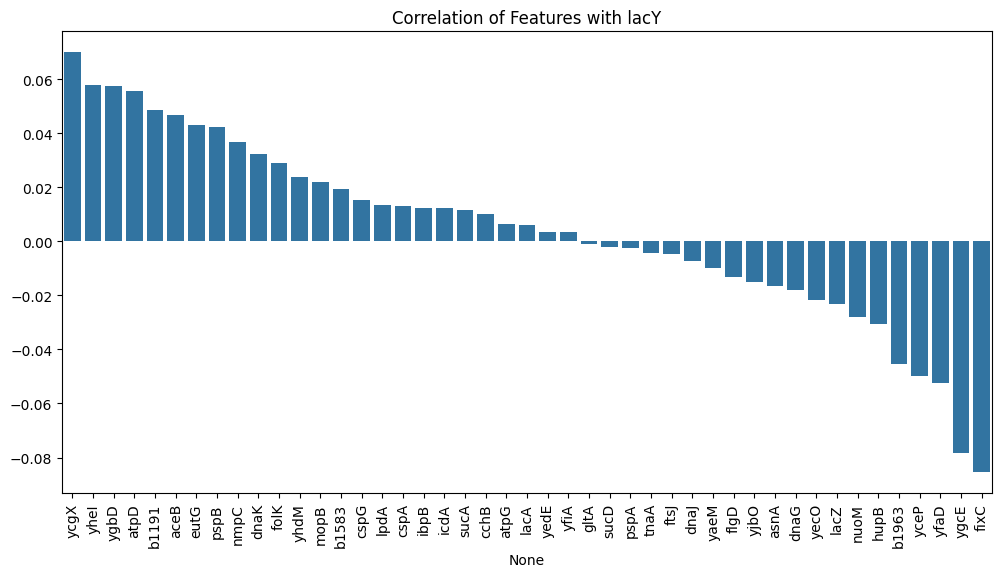

In [ ]:
# Initialise correlation matrix
correlation_matrix = data.corr()
correlations_with_target = correlation_matrix[target_column].drop(target_column).sort_values(ascending=False) # Drop target column

# Plot correlation plot
plt.figure(figsize=(12, 6))
sns.barplot(x=correlations_with_target.index, y=correlations_with_target.values)
plt.xticks(rotation=90)
plt.title("Correlation of Features with lacY")
plt.show()


This bar chart shows the correlation of each feature with the target lacY. Most features have a weak correlation, with only a few showing modest positive or negative relationships. This suggests that no single feature strongly predicts lacY.

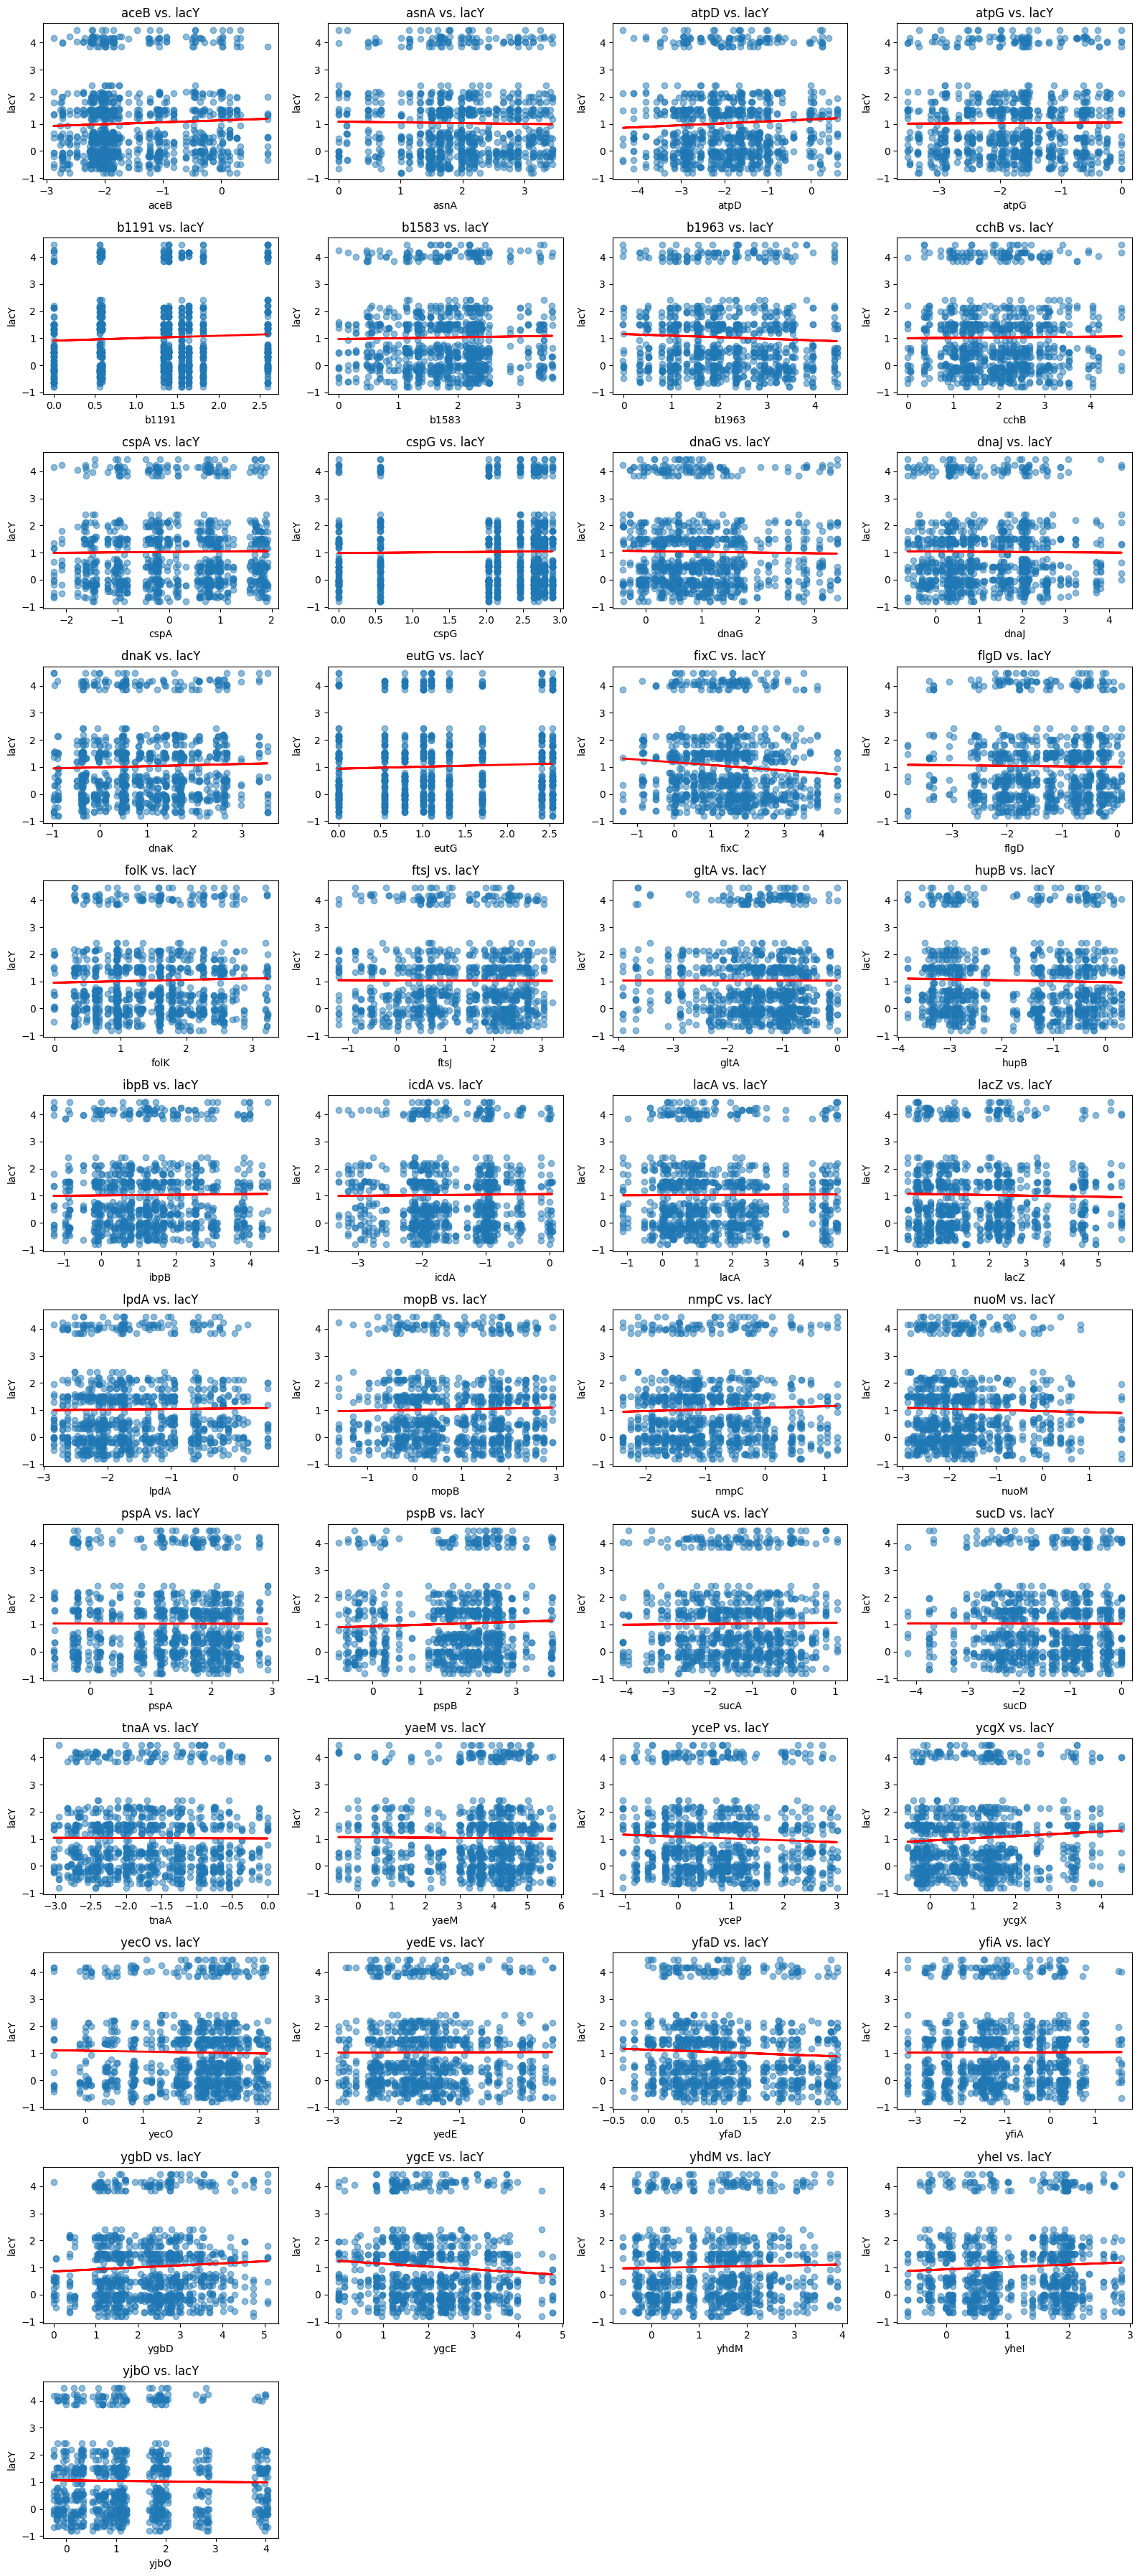

In [ ]:
# Get all feature column names excluding target column
features = data.drop(columns='lacY').columns
n_features = len(features)  # Total number of input features

# Set the number of subplot columns and calculate rows needed for the grid
cols = 4
rows = math.ceil(n_features / cols)

plt.figure(figsize=(cols * 4, rows * 3))

# Loop through each feature and plot it against target
for i, feature in enumerate(features, 1):
    plt.subplot(rows, cols, i)
    x = data[feature]
    y = data['lacY']
    plt.scatter(x, y, alpha=0.5)
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m * x + b, color='red', linewidth=2)
    plt.xlabel(feature)
    plt.ylabel('lacY')
    plt.title(f'{feature} vs. lacY')

plt.tight_layout()
plt.show()


These scatter plots show the relationship between each input gene and the target lacY. Most plots reveal very weak or no clear trend, with the red regression lines appearing mostly flat. This further supports the idea that no individual gene has a strong linear relationship with lacY, indicating thatg there could be limited predictive power in the feature set.

<Figure size 1600x3600 with 0 Axes>

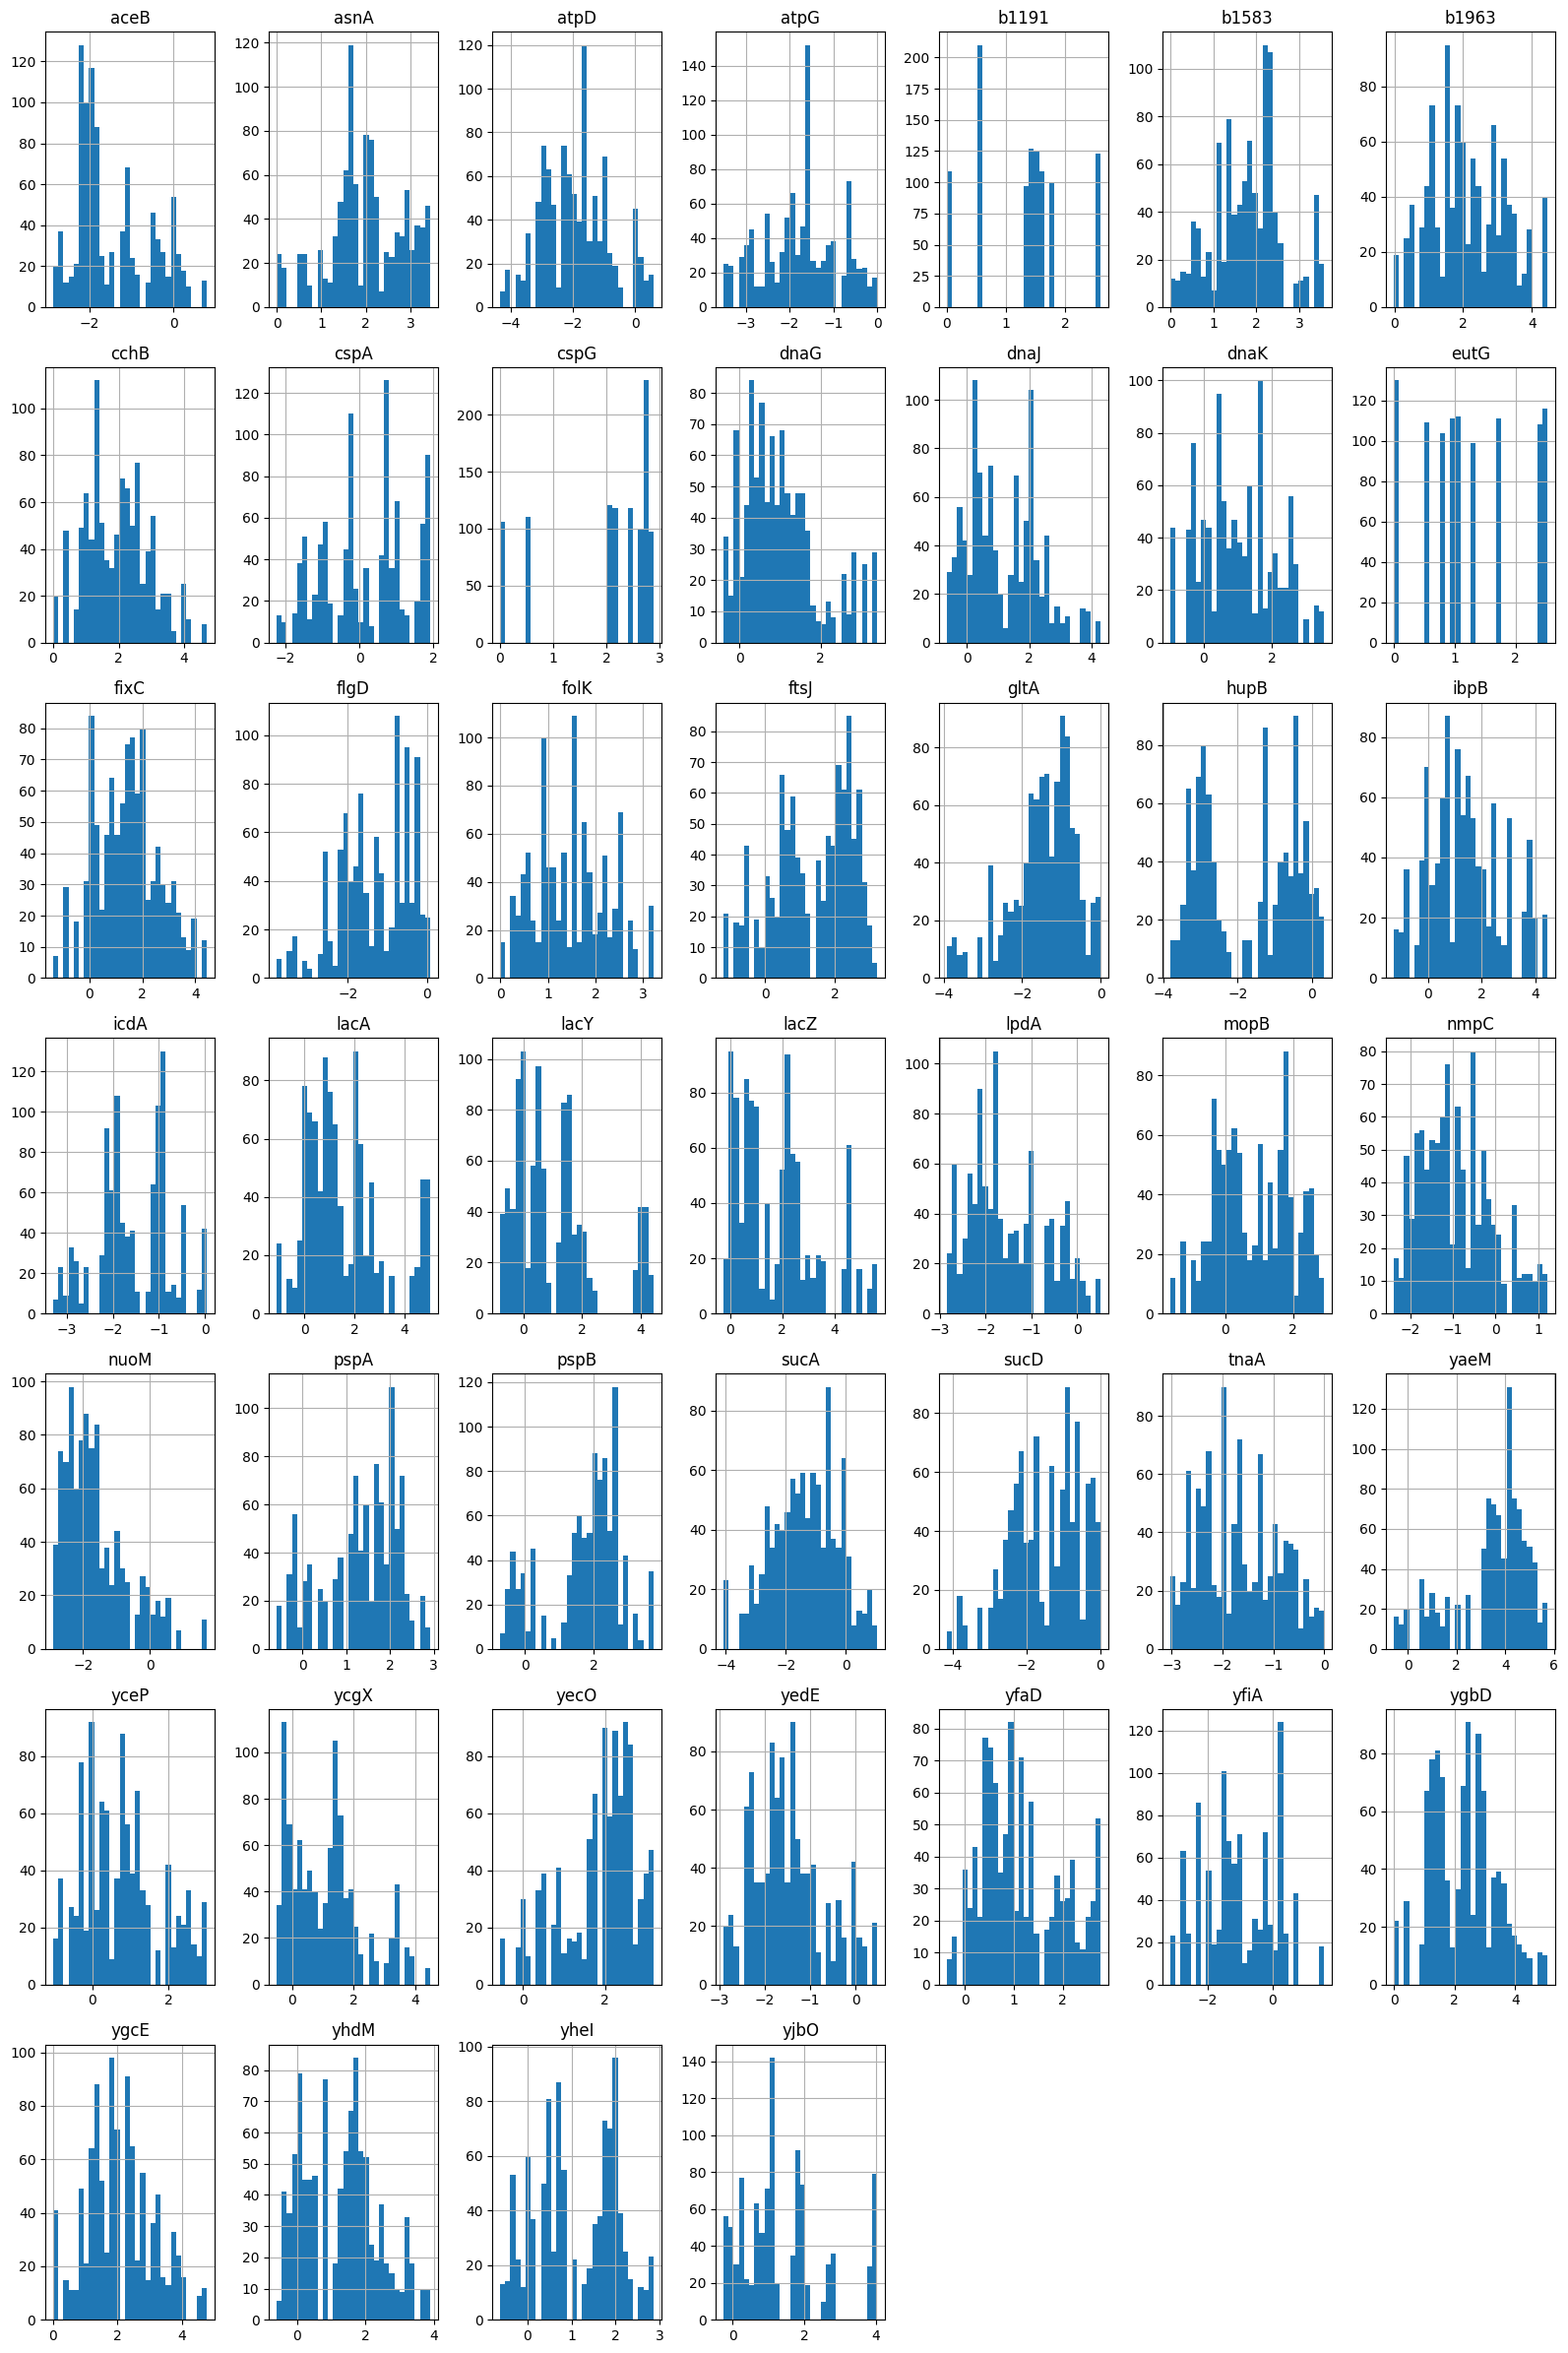

In [ ]:
# Plot histograms of data

n = data.shape[1]
cols = 4
rows = math.ceil(n / cols)

plt.figure(figsize=(cols * 4, rows * 3))
data.hist(bins=30, figsize=(cols * 4, rows * 2))
plt.tight_layout()
plt.show()

This set of histograms shows the distribution of gene expression values across all features, including the target lacY. Most features exhibit irregular distributions, which suggests a high degree of biological and experimental variability, which may limit predictive power of our model.

### 2.3 Data Splitting

Before training the model, the dataset was split into training, validation, and test sets. To ensure a balanced distribution of the target variable lacY across these subsets, StratifiedShuffleSplit was used. 

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

# StratifiedShuffleSplit requires categorical labels, so we can discretize 'lacY' for stratification
y_binned = pd.qcut(y, q=10, labels=False)  # Binning the target into 10 discrete categories

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_val_index, test_index in strat_split.split(X, y_binned):
    X_train_val, X_test = X.iloc[train_val_index], X.iloc[test_index]
    y_train_val, y_test = y.iloc[train_val_index], y.iloc[test_index]

# Further split Train+Val into Train and Validation sets using Stratified Shuffle Split
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
for train_index, val_index in strat_split.split(X_train_val, pd.qcut(y_train_val, q=10, labels=False)):
    X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]

print("Train set size:", X_train.shape, y_train.shape)
print("Val   set size:", X_val.shape, y_val.shape)
print("Test  set size:", X_test.shape, y_test.shape)


Train set size: (600, 45) (600,)
Val   set size: (200, 45) (200,)
Test  set size: (200, 45) (200,)


Since stratification requires categorical labels, the continuous lacY values were binned into deciles using pd.qcut.

This approach helps preserve the distribution of lacY in each subset and ensures that all value ranges are represented during training and evaluation.

In [ ]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on training data and transform the training set
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled arrays back to DataFrames with original column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

# Save the scaler for later use (e.g., for deploying the model)
joblib.dump(scaler, 'scaler.pkl')

# Checking the scaled data
print("Train scaled data:\n", X_train_scaled.head())

Train scaled data:
        aceB      asnA      atpD      atpG     b1191     b1583     b1963  \
0 -0.353030  0.138845  0.188987 -0.674107  0.166238 -0.617774  0.210944   
1 -0.878763 -1.159211 -0.616041  0.667118  0.729884 -0.837797  0.210944   
2  0.394316 -0.001522 -0.811903 -1.469554  0.166238 -1.116033 -2.023172   
3 -0.633529 -0.264575  1.118827 -0.394256  0.496220  0.011088 -1.706864   
4  1.291332 -2.212626  0.776275 -0.809800  0.386584  0.025475 -1.538274   

       cchB      cspA      cspG  ...      ycgX      yecO      yedE      yfaD  \
0 -0.588492 -1.031140  0.642528  ...  1.159153  0.925352  1.895516 -0.191505   
1 -0.064709  0.695225  0.794329  ... -0.466818  0.754855 -0.839230 -0.603365   
2  1.708324 -1.427381  0.123637  ...  1.945257  1.534203 -1.172233 -0.526608   
3  0.593374 -0.427827  0.642528  ...  0.312359  0.945878 -1.106231 -0.245395   
4  0.719453 -1.063563 -1.550186  ...  0.233348  0.162080 -0.882054 -0.226293   

       yfiA      ygbD      ygcE      yhdM      y

To prepare the input data for neural network training, standardisation was applied using StandardScaler. The scaler was fit only on the training set to prevent data leakage, then applied to the validation and test sets using transform().

After scaling, the arrays were converted back into DataFrames to retain feature names for consistency in analysis and debugging.

To support future reuse or deployment, the fitted scaler can be saved using joblib.dump(), ensuring identical preprocessing is applied during inference.

### 2.4 Feature Selection

A variety of feature selection techniques were applied to assess the importance of genes in predicting lacY. These included correlation analysis, mutual information, recursive feature elimination (RFE), and regularised regression methods such as Lasso and ElasticNet. Each method offers a different perspective. Additionally, PCA was used to estimate the dimensionality required to retain most of the variance in the dataset. This multi-method approach aimed to capture a more comprehensive view of feature importance.

#### 2.4.1 Correlation Analysis

In [ ]:
def correlation_analysis(X, y):
    corr_scores = abs(X.corrwith(pd.Series(y))).sort_values(ascending=False)
    return corr_scores

#### 2.4.2 Mutual Information

In [ ]:
def mutual_information(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
    return mi_scores

#### 2.4.3 Recursive Feature Elimination (RFE)

In [ ]:
def recursive_feature_elimination(X, y, n_features=10):
    model = LinearRegression()
    rfe = RFE(estimator=model, n_features_to_select=n_features)
    rfe.fit(X, y)
    rfe_scores = pd.Series(rfe.support_, index=X.columns)
    return rfe_scores[rfe_scores == True]

#### 2.4.4 LASSO (L1 Regularization)

In [ ]:
def lasso_selection(X, y, alpha=0.01):
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    lasso_scores = pd.Series(lasso.coef_, index=X.columns)
    return lasso_scores[lasso_scores != 0]

#### 2.4.5 ElasticNet (L1 + L2 Regularization)

In [ ]:
def elasticnet_selection(X, y, alpha=0.01, l1_ratio=0.5):
    elastic_net = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    elastic_net.fit(X, y)
    elastic_net_scores = pd.Series(elastic_net.coef_, index=X.columns)
    return elastic_net_scores[elastic_net_scores != 0]

#### 2.4.6 Dimensionality Reduction (PCA)

In [ ]:
def pca_selection(X, n_components=0.95):
    pca = PCA(n_components=n_components)
    pca.fit(X)
    n_selected_components = len(pca.explained_variance_ratio_)
    return n_selected_components

#### 2.4.7 Combine and Rank Features

Each method returns a different type of score or selection logic, so the results were normalised between 0 and 1 using MinMaxScaler to allow fair comparison. A combined score was then calculated by averaging across all methods.

The top 10 features based on this aggregated score were selected for further model training.

In [ ]:
# Collecting feature selection results
feature_scores = pd.DataFrame(index=X_train_scaled.columns)

# Apply all methods
feature_scores['Correlation'] = correlation_analysis(X_train_scaled, y_train)
feature_scores['Mutual Information'] = mutual_information(X_train_scaled, y_train)
feature_scores['RFE'] = recursive_feature_elimination(X_train_scaled, y_train)
feature_scores['LASSO'] = lasso_selection(X_train_scaled, y_train)
feature_scores['ElasticNet'] = elasticnet_selection(X_train_scaled, y_train)

# Replace NaN values with 0 for methods where features were not selected
feature_scores = feature_scores.fillna(0)

# Normalize all scores between 0 and 1 for comparison
scaler = MinMaxScaler()
feature_scores_normalized = pd.DataFrame(scaler.fit_transform(feature_scores), 
                                         index=feature_scores.index, 
                                         columns=feature_scores.columns)

# Calculate average score across all methods
feature_scores_normalized['Combined_Score'] = feature_scores_normalized.mean(axis=1)

# Sort features by their combined score
feature_importance = feature_scores_normalized['Combined_Score'].sort_values(ascending=False)

# Select top 10 features
top_features = feature_importance.head(10).index.tolist()
print("Top Selected Features:\n", top_features)

Top Selected Features:
 ['atpD', 'ycgX', 'ygbD', 'ibpB', 'yheI', 'cspA', 'cspG', 'hupB', 'ygcE', 'pspB']


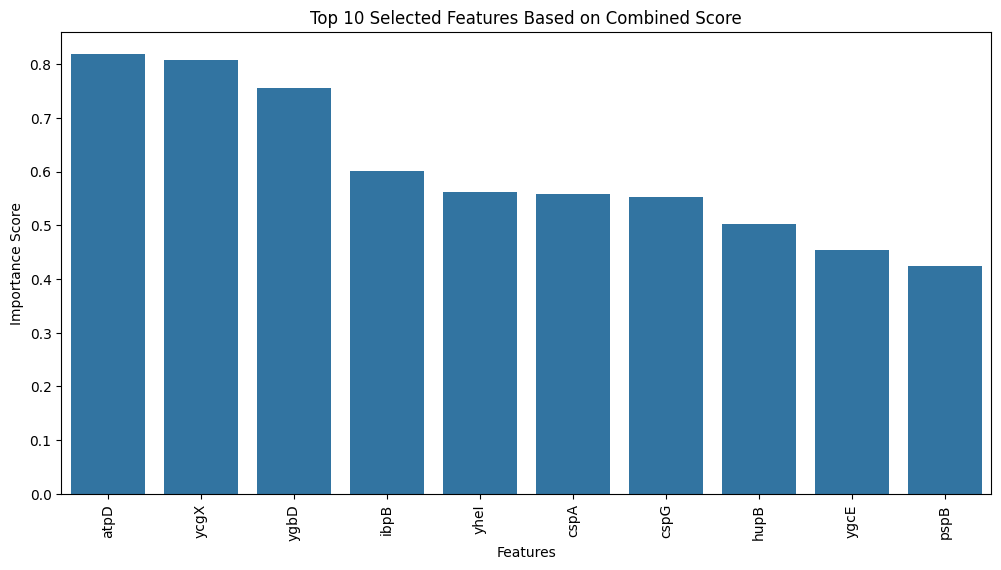

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importance.head(10).index, y=feature_importance.head(10).values)
plt.title("Top 10 Selected Features Based on Combined Score")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.xticks(rotation=90)
plt.show()


The bar chart below shows the top 10 genes selected through our combined scoring approach, the highest-ranking features include atpD, ycgX, and ygbD, suggesting these may have the most influence on predicting lacY.

This method ensures that feature selection isn't biased by a single technique and provides a more balanced view of feature relevance.

### 2.5 Data Preparation

Before training the model, the dataset was prepared. Feature values were standardised using StandardScaler, which was fit on the training set and applied to the validation and test sets to avoid data leakage. The scaled arrays were converted back to DataFrames to retain column names for consistency.

Finally, the data was converted into PyTorch tensors and wrapped into TensorDataset and DataLoader objects to enable efficient batch processing during training.

In [ ]:
# Use the selected features for training, validation, and testing
X_train_selected = X_train_scaled[top_features]
X_val_selected = X_val_scaled[top_features]
X_test_selected = X_test_scaled[top_features]

print("Selected Feature Set Shape:", X_train_selected.shape)

# Confirm shape
print("Training Set Shape:", X_train_selected.shape)
print("Validation Set Shape:", X_val_selected.shape)
print("Testing Set Shape:", X_test_selected.shape)

Selected Feature Set Shape: (600, 10)
Training Set Shape: (600, 10)
Validation Set Shape: (200, 10)
Testing Set Shape: (200, 10)


In [ ]:
# Convert to DataFrame to retain column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=top_features)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=top_features)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=top_features)

# Save scaler for later use (e.g., deployment)
joblib.dump(scaler, 'scaler_selected_features.pkl')

# Convert numpy arrays to tensors
X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)

X_val_tensor = torch.tensor(X_val_scaled.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values.reshape(-1, 1), dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)

# Creating DataLoader objects for batch processing
batch_size = 8

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Confirming DataLoader sizes
print(f'Train loader batches: {len(train_loader)}')
print(f'Validation loader batches: {len(val_loader)}')
print(f'Test loader batches: {len(test_loader)}')

Train loader batches: 75
Validation loader batches: 25
Test loader batches: 25


## 3 Model Implementation

### 3.1 Building Neural Network Model

In [ ]:
# Define the neural network model
class GeneExpressionNN(nn.Module):
    def __init__(self, input_size, hidden_size1=64, hidden_size2=32, output_size=1, dropout_rate=0.2):
        super(GeneExpressionNN, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.fc3 = nn.Linear(hidden_size2, output_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        
        x = self.fc3(x)  # No activation function for regression
        return x


### 3.2 Model Justification

The model created is a feedforward neural network designed for predicting gene expression levels using other gene expression features as input. This model architecture is tailored to regression tasks and is particularly suited to biological data, where relationships between variables are often complex and nonlinear.

The network begins with an input layer sized to match the number of features used—typically a subset of genes selected through feature selection techniques. By reducing the number of input variables, the model can focus on the most relevant predictors and reduce the impact of noise, which is especially important in high-dimensional datasets like gene expression profiles.

It includes two hidden layers with 64 and 32 units respectively. This setup provides enough capacity to model complex patterns in the data while keeping the model relatively lightweight. The layered design helps the network learn increasingly abstract representations of the input, which can improve prediction accuracy on unseen data.

Each hidden layer is followed by a ReLU activation function. ReLU is widely used in deep learning due to its ability to introduce nonlinearity without causing vanishing gradient issues that are common with older activation functions like sigmoid or tanh. This allows the network to learn more effectively during training.

To prevent overfitting, dropout is applied after each hidden layer with a rate of 0.2. Dropout randomly disables a portion of the neurons during training, forcing the network to avoid relying too heavily on specific nodes and encouraging it to learn more general features that are useful across different training examples.

The output layer consists of a single neuron with no activation function, which is the standard configuration for regression problems. It outputs a continuous value corresponding to the predicted expression level of the target gene (e.g., lacY).

Overall, this architecture strikes a good balance between flexibility, performance, and simplicity, making it well-suited for our gene expression prediction task.

### 3.3 Initialise the Model, Define Loss Function & Optimizer

In [ ]:
# Hyperparameters
input_size = len(top_features)  # Number of selected features
hidden_size1 = 64
hidden_size2 = 32
output_size = 1
dropout_rate = 0.2
learning_rate = 0.001

# Initialize the model
model = GeneExpressionNN(input_size, hidden_size1, hidden_size2, output_size, dropout_rate).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


GeneExpressionNN(
  (fc1): Linear(in_features=10, out_features=64, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

## 4 Training and Optimisation

### 4.1 Training The Model

The model is trained using Mean Squared Error (MSE) as the loss function. MSE is appropriate for regression as it penalizes larger errors more than smaller ones, which helps the model focus on minimising the most significant mistakes. The optimiser used is Adam, which is a popular choice due to its adaptive learning rate and robust performance across a wide range of problems.

In [ ]:
%%capture
# Training function
def train(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move to device
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss

# Validation function
def validate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move to device
            
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch)
            running_loss += loss.item() * X_batch.size(0)

    epoch_loss = running_loss / len(val_loader.dataset)
    return epoch_loss

# Hyperparameters
num_epochs = 10  # Start with 10 to test stability
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer)
    val_loss = validate(model, val_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')


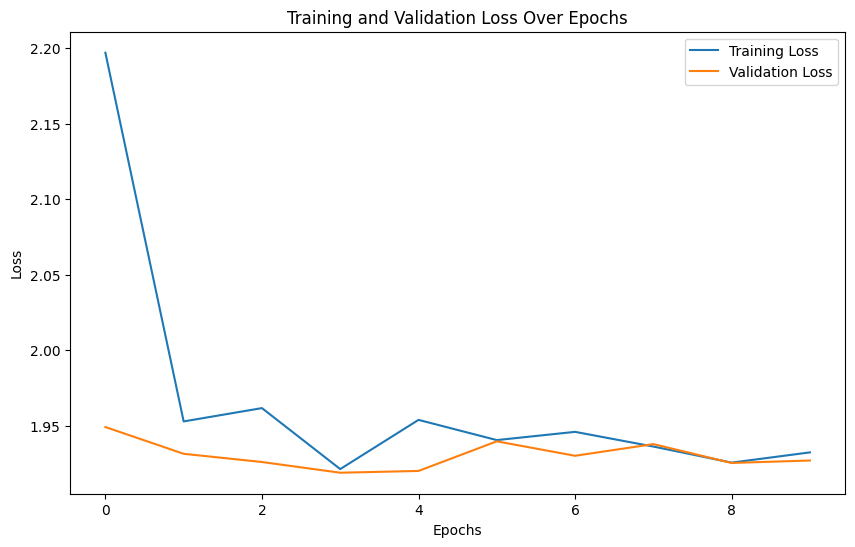

In [ ]:
# Plotting training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The training and validation losses decrease over the first few epochs and remain close throughout, with some minor fluctuations. This suggests the model is learning without overfitting, although the overall loss remains relatively high and stable. The similar values between training and validation loss indicate that the model generalises consistently but may be limited by the data or its expressive power.

To improve model performance, Optuna was used to optimise the following hyperparameters:

hidden_size1: Number of neurons in the first hidden layer

hidden_size2: Number of neurons in the second hidden layer

dropout_rate: Dropout applied after each hidden layer to prevent overfitting

learning_rate: Learning rate for the Adam optimiser

batch_size: Batch size for DataLoader during training

The objective() function trains the model for a fixed number of epochs and evaluates it on the validation set. Optuna’s pruning mechanism was enabled to terminate unpromising trials early, saving computational resources.

### 4.2 Optimise the Hyperparameters

In [ ]:
def clear_gpu_memory():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

clear_gpu_memory()

def objective(trial):
    set_seed(42)
    hidden_size1 = trial.suggest_int('hidden_size1', 32, 128)
    hidden_size2 = trial.suggest_int('hidden_size2', 16, 64)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = GeneExpressionNN(input_size, hidden_size1, hidden_size2, output_size, dropout_rate).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    num_epochs = 10  # Reduce to 10 for testing stability
    for epoch in range(num_epochs):
        train(model, train_loader, criterion, optimizer)
        val_loss = validate(model, val_loader, criterion)
        
        # Report intermediate results to Optuna and enable pruning
        trial.report(val_loss, epoch)
        
        if trial.should_prune():
            raise TrialPruned()
    
    # Clear GPU memory if applicable
    clear_gpu_memory()
    
    return val_loss

# Initialize Optuna study
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=10) 

/var/folders/32/6zl37k_j123fgy6v2_4hf4_40000gn/T/ipykernel_39363/1481756934.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([24, 1])) that is different to the input size (torch.Size([24])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  r

In [ ]:
print("Best hyperparameters found:")
print(study.best_params)

Best hyperparameters found:
{'hidden_size1': 110, 'hidden_size2': 30, 'dropout_rate': 0.13906884560255356, 'learning_rate': 0.0023359635026261607, 'batch_size': 32}


The best trial achieved a validation loss of 1.9090, with the following hyperparameters:

hidden_size1: 110

hidden_size2: 30

dropout_rate: 0.139

learning_rate: 0.00234

batch_size: 32

These values were used in the final model configuration.

### 4.3 Final Model

In [ ]:
%%capture
# Best hyperparameters from Optuna
best_hidden_size1 = 110
best_hidden_size2 = 30
best_dropout_rate = 0.139
best_learning_rate = 0.00234
best_batch_size = 32

# Update DataLoader with best batch size
train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=best_batch_size, shuffle=False)

# Initialize the model with optimal hyperparameters
model = GeneExpressionNN(
    input_size=input_size,
    hidden_size1=best_hidden_size1,
    hidden_size2=best_hidden_size2,
    output_size=output_size,
    dropout_rate=best_dropout_rate
).to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_learning_rate)

num_epochs = 1000  # You can increase to improve performance
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer)
    val_loss = validate(model, val_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

torch.save(model.state_dict(), 'best_model.pth')

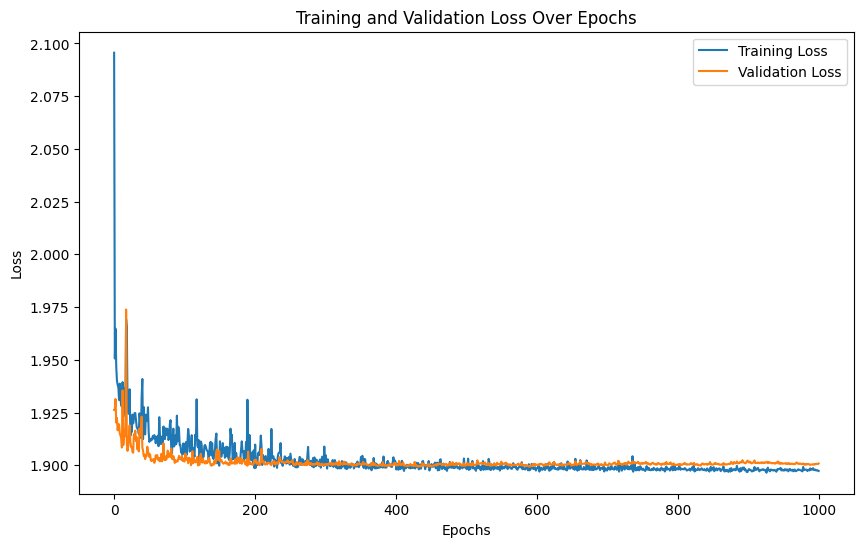

In [ ]:
# Plotting training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The plot shows the training and validation loss over 1,000 epochs using the final model configuration. Both losses decrease rapidly in the early epochs and then stabilise, converging closely from around epoch 100 onwards.

Since the curves stick close together this indicates that the model generalises well without overfitting. However, the gradual plateau in both losses suggests that further improvements may be limited by the quality or informativeness of the input features.

## 5 Evaluation & Interpretation

This section presents the final performance of the trained model using standard regression metrics. The aim is to assess how well the model generalises to unseen data. Both numerical scores and visualisations are used to support the evaluation.

In [ ]:
# Test Evaluation
test_loss = validate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}')


Test Loss: 1.9107


This score is consistent with validation performance and confirms that the model generalises similarly on unseen data.

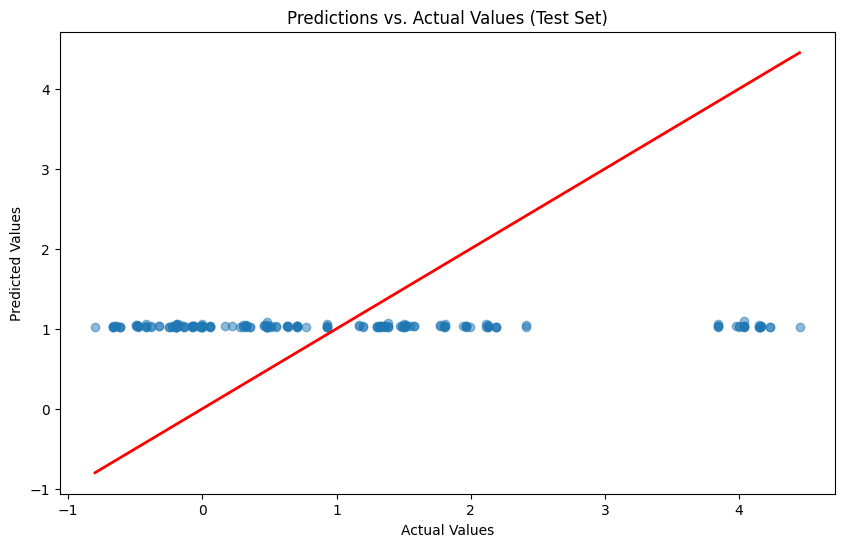

In [ ]:
# Function to make predictions
def predict(model, loader):
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            predictions.append(outputs.cpu().numpy())
            actuals.append(y_batch.numpy())
    
    predictions = np.concatenate(predictions).squeeze()
    actuals = np.concatenate(actuals).squeeze()
    
    return predictions, actuals

# Get predictions and actual values from the test set
predictions, actuals = predict(model, test_loader)

# Plotting Predictions vs Actuals
plt.figure(figsize=(10, 6))
plt.scatter(actuals, predictions, alpha=0.5)
plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], color='red', lw=2)
plt.title('Predictions vs. Actual Values (Test Set)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


The scatter plot compares the model’s predicted lacY values to the actual values from the test set. Ideally, points would align closely with the red diagonal line, which represents perfect predictions.

In this case, most predictions are clustered around the mean, showing minimal variation in output. This suggests the model has learned to predict values near the mean, rather than capturing the full range of the target distribution. The lack of spread indicates limited predictive power, likely due to weak signal in the input features.



In [ ]:
# Calculate regression metrics
mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Squared Error (MSE): 1.9093
Mean Absolute Error (MAE): 1.1064
R² Score: 0.0006


These results indicate that the model was unable to significantly outperform a baseline that predicts the mean of the target. The near-zero R² score suggests that the features provide limited predictive signal for lacY, despite extensive model tuning and optimisation.

## 6 Discussion & Improvements

This project applied a range of advanced neural network techniques to predict the lacY gene expression level. Feature selection was carried out using multiple model-based and statistical methods, and hyperparameter tuning was conducted using Optuna with pruning to efficiently explore architectural and training configurations. Dropout and adaptive learning (Adam optimiser) were used to improve generalisation, and extensive evaluation was performed using multiple regression metrics. Despite these efforts, the model achieved a near-zero R² score, indicating limited predictive power from the available input features.

One likely explanation is that the dataset lacks sufficient signal for the model to learn from. The weak correlation between input genes and lacY, along with the flat prediction distribution, suggests the model was unable to capture meaningful relationships. While the architecture generalised well (as indicated by stable training and validation losses), the absence of performance gain implies that even advanced regularisation and tuning strategies were insufficient without more informative or structured data.

To improve performance, future work could focus on enhancing the quality and variety of the dataset. This could include incorporating additional features, such as time-series data to capture temporal gene expression patterns or external biological data, like gene regulatory networks or transcription factor activity. These additions would provide more context to the model, potentially helping it identify more complex relationships between genes. Furthermore, cleaning the data to address noise or missing values could lead to better model generalisation.

Another avenue for improvement could involve experimenting with simpler models or ensemble techniques that might be more suitable for high-dimensional, noisy datasets. For instance, Random Forests or XGBoost could offer better performance in capturing nonlinear relationships. Additionally, exploring feature engineering techniques to extract meaningful relationships, such as interactions between genes or principal components, might provide a more informative set of inputs for the model.